# PENGUMPULAN DATA

In [64]:
import requests
import csv
from collections import deque
from math import ceil

# Daftar alamat awal
initial_addresses = [
    "0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae",
    "0x742d35cc6634c0532925a3b844bc454e4438f44e",
    "0x66f820a414680b5bcda5eeca5dea238543f42054",
    "0x177d39AC676ED1C67A2b268AD7F1E58826E5B0af",
    "0x39Bb259F66E1C59d5ABEF88375979b4D20D98022",
    "0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0",
    "0x4E15361FD6b4BB609Fa63C81A2be19d873717870"
]
api_key = "BEE8WYV36N1B8X54CDMPMCNCBYPPJSTS9B"
transactions = []
max_depth = 2  # Batas lapisan eksplorasi
max_iterations = 25  # Batas eksplisit untuk menghindari infinite loop
visited_addresses = set(initial_addresses)  # Untuk menghindari duplikasi
queue = deque([(address, 0) for address in initial_addresses])  # (alamat, kedalaman)

iterations = 0

all_all_transaction = 0
while queue and iterations < max_iterations:
    address, depth = queue.popleft()
    iterations += 1

    if depth >= max_depth:
        continue

    # Permintaan API untuk transaksi
    url = f"https://api.etherscan.io/api?module=account&action=txlist&address={address}&startblock=0&endblock=99999999&sort=asc&apikey={api_key}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if data['status'] == '1':  # Status '1' berarti berhasil
            all_transactions = data['result']
            limit = ceil(0.02 * len(all_transactions))  # Ambil 20% data teratas
            selected_transactions = all_transactions[:limit]

            for tx in selected_transactions:
                transactions.append(tx)
                # Tambahkan alamat baru ke antrean jika belum dikunjungi
                if tx['from'] not in visited_addresses:
                    visited_addresses.add(tx['from'])
                    queue.append((tx['from'], depth + 1))
                if tx['to'] not in visited_addresses:
                    visited_addresses.add(tx['to'])
                    queue.append((tx['to'], depth + 1))
            all_trans = len(all_transactions)
            print(f"Alamat {address}: {len(selected_transactions)} transaksi diproses (dari total {all_trans}).")
            all_all_transaction += all_trans
        else:
            print(f"Alamat {address}: Tidak ada data ditemukan atau ada masalah - {data['message']}")
    else:
        print(f"Alamat {address}: Permintaan gagal - {response.status_code}")

# Simpan semua transaksi ke CSV
with open('transactions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['blockNumber', 'timeStamp', 'from', 'to', 'value'])
    for tx in transactions:
        writer.writerow([tx['blockNumber'], tx['timeStamp'], tx['from'], tx['to'], tx['value']])
print(f"Total transaksi disimpan: {len(transactions)} dari {all_all_transaction} transaksi yang diproses.")


Alamat 0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae: 53 transaksi diproses (dari total 2650).
Alamat 0x742d35cc6634c0532925a3b844bc454e4438f44e: 200 transaksi diproses (dari total 10000).
Alamat 0x66f820a414680b5bcda5eeca5dea238543f42054: 5 transaksi diproses (dari total 210).
Alamat 0x177d39AC676ED1C67A2b268AD7F1E58826E5B0af: 200 transaksi diproses (dari total 10000).
Alamat 0x39Bb259F66E1C59d5ABEF88375979b4D20D98022: 200 transaksi diproses (dari total 10000).
Alamat 0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0: 200 transaksi diproses (dari total 10000).
Alamat 0x4E15361FD6b4BB609Fa63C81A2be19d873717870: 200 transaksi diproses (dari total 10000).
Alamat 0x5abfec25f74cd88437631a7731906932776356f9: 1 transaksi diproses (dari total 18).
Alamat : Tidak ada data ditemukan atau ada masalah - NOTOK
Alamat 0x3fb1cd2cd96c6d5c0b5eb3322d807b34482481d4: 1 transaksi diproses (dari total 33).
Alamat 0x063dd253c8da4ea9b12105781c9611b8297f5d14: 1 transaksi diproses (dari total 45).
Alamat 0x7c56d94ebeccb

# IMPORT DATA

In [65]:
import pandas as pd

# Baca data transaksi
data = pd.read_csv('/makalah_matdis/transactions.csv')
print(data.head())  # Tampilkan beberapa baris pertama


   blockNumber   timeStamp                                        from  \
0      4821783  1514603772  0x72da476b2e4eb2062ebebcdd2356d965c36bf997   
1      4810735  1514439359  0xf4738f00268e021b40d36ab80aeadfcc484f4637   
2      4144163  1502450171  0x2ebb507b1da5b2619515d542a8af27b0747a6bc2   
3      4811010  1514443397  0x28e5a8c8243c874ef1efa61f5b9e531ef409cd65   
4     17809745  1690767299  0xc40a1e189d618785265ce02afd2640e7705a0349   

                                           to value  
0  0x39bb259f66e1c59d5abef88375979b4d20d98022     0  
1  0x39bb259f66e1c59d5abef88375979b4d20d98022     0  
2  0x177d39ac676ed1c67a2b268ad7f1e58826e5b0af     0  
3  0x39bb259f66e1c59d5abef88375979b4d20d98022     0  
4  0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae   840  


# MEMBUAT GRAF BERARAH

In [66]:
import networkx as nx

# Inisialisasi graf berarah
G = nx.DiGraph()

# Tambahkan edge ke graf
for _, row in data.iterrows():
    sender = row['from']
    receiver = row['to']
    value = float(row['value']) / 1e18  # Konversi wei ke ether
    G.add_edge(sender, receiver, weight=value)

print(f"Graf dibuat dengan {G.number_of_nodes()} simpul dan {G.number_of_edges()} sisi.")


Graf dibuat dengan 2171 simpul dan 2172 sisi.


# ANALISIS GRAF DASAR

### HITUNG JUMLAH NODES

In [67]:
print("Jumlah simpul:", G.number_of_nodes())
print("Jumlah sisi:", G.number_of_edges())


Jumlah simpul: 2171
Jumlah sisi: 2172


###  SENTRALITAS DEGREE

In [68]:
in_degree = G.in_degree(weight='weight')
out_degree = G.out_degree(weight='weight')

top_in = max(in_degree, key=lambda x: x[1])
top_out = max(out_degree, key=lambda x: x[1])

print("Alamat dengan transaksi masuk tertinggi:", top_in)
print("Alamat dengan transaksi keluar tertinggi:", top_out)


Alamat dengan transaksi masuk tertinggi: ('0xc61b9bb3a7a0767e3179713f3a5c7a9aedce193c', 199999.99999999997)
Alamat dengan transaksi keluar tertinggi: ('0x742d35cc6634c0532925a3b844bc454e4438f44e', 219999.99999999997)


### DISTRIBUSI BERAT EDGE

In [70]:
max_edge = max(G.edges(data=True), key=lambda x: x[2]['weight'])
print("Transaksi dengan nilai terbesar:", max_edge)


Transaksi dengan nilai terbesar: ('0x742d35cc6634c0532925a3b844bc454e4438f44e', '0xc61b9bb3a7a0767e3179713f3a5c7a9aedce193c', {'weight': 199999.99999999997})


# VISUALISASI GRAF

### VISUALISASI DASAR DENGAN MATPLOTLIB

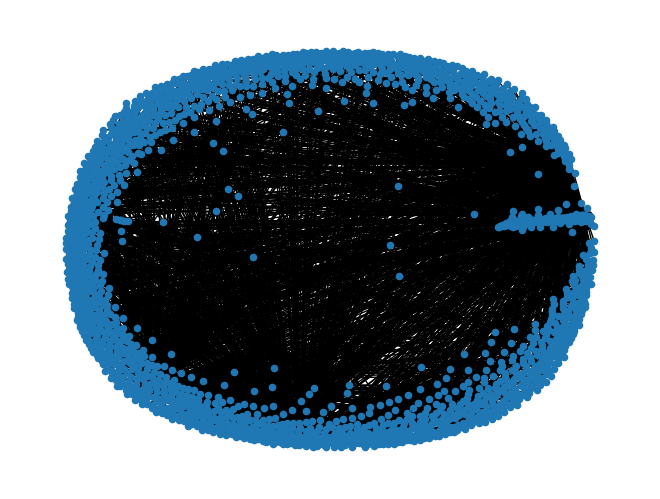

In [71]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)  # Tata letak posisi node
nx.draw(G, pos, node_size=20, with_labels=False)
plt.show()


### VISUALISASI LANJUTAN

In [72]:
nx.write_graphml(G, "graph.graphml")


# ANALISIS LANJUTAN

### DETEKSI KOMUNITAS

In [73]:
from networkx.algorithms.community import greedy_modularity_communities

# Deteksi komunitas
communities = list(greedy_modularity_communities(G))
print(f"Jumlah komunitas ditemukan: {len(communities)}")

# Tampilkan beberapa komunitas
for i, community in enumerate(communities[:5], 1):  # Batas 5 komunitas pertama
    print(f"Komunitas {i}: {community}")


Jumlah komunitas ditemukan: 6
Komunitas 1: frozenset({'0x7bb26b220fe5de852e63ed22e692fb07ef17b188', '0x83d47672eb236463dd6cfc51e4448c2f9a241455', '0x2dd92af178207c4e7596c74df7a4b11ce89c840f', '0x7b55abb2e7ba9979a16b830063905c665c3816b8', '0xaf93240183b782709e9dea4513d2a7fd580cf979', '0xb5fdc1351fe71e7b9dbe9e60c92920b6ee90b29a', '0xefd61ab7a1499eaa0b625d01f698d944d37fb6ef', '0x204d8a468bdffb39af686422cd5b685b25504a9d', '0x514a441ca019d84f5b71a23e850d8ae00318a250', '0xe55ed4db7445216c705a52c55f9598b074c10b3b', '0x55d6cbfa9f66f838b81e4ae8224fea5a10396cd8', '0xda70ca8ed51a7a8e67376fbc22415106da92dce8', '0x21b77214b5e5f4453f115f5314a91db4efc90bcb', '0xc88fceaae142a782036552fc3a9edc6c3171baa1', '0xe0a9acd9d4eea7a7e5c5e6d658d70a73834e1b6d', '0xeaf13effb1b96dc151ce647c9c684d6b705a6d83', '0x83dc0c1aee82abc9693cc71776ea12216ab17db1', '0x2e183c8af4f72acb09d525a8cf02f41e742f3749', '0xff33c75d6360d8d7517b783799e9d15fcd87d276', '0x3612778192fdf3ce85ec41eba04d68fc1794d259', '0x100deee5a17ffbc3adfee9a

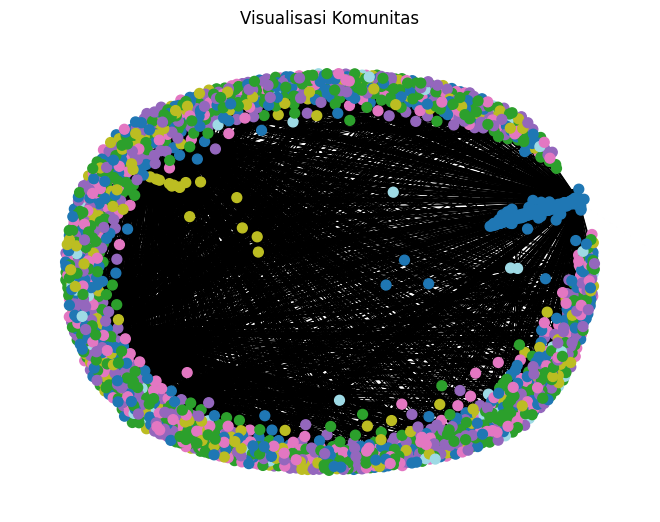

In [80]:
import matplotlib.pyplot as plt
import networkx as nx

# Buat peta komunitas
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# Visualisasi
pos = nx.spring_layout(G)  # Posisi node
node_colors = [community_map[node] for node in G.nodes()]
nx.draw(
    G, pos, node_color=node_colors, cmap=plt.cm.tab20, with_labels=False, node_size=50
)
plt.title("Visualisasi Komunitas")
plt.show()


In [81]:
# Analisis komunitas terbesar
largest_community = max(communities, key=len)
subgraph = G.subgraph(largest_community)

# Node dengan derajat tertinggi dalam komunitas
degree_centrality = nx.degree_centrality(subgraph)
important_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Node penting dalam komunitas terbesar:")
for node, centrality in important_nodes:
    print(f"{node}: Centrality {centrality:.4f}")


Node penting dalam komunitas terbesar:
0x4e15361fd6b4bb609fa63c81a2be19d873717870: Centrality 1.0000
0x7bb26b220fe5de852e63ed22e692fb07ef17b188: Centrality 0.0014
0x83d47672eb236463dd6cfc51e4448c2f9a241455: Centrality 0.0014
0x2dd92af178207c4e7596c74df7a4b11ce89c840f: Centrality 0.0014
0x7b55abb2e7ba9979a16b830063905c665c3816b8: Centrality 0.0014


In [82]:
# Cari edge lintas komunitas
cross_community_edges = [
    (u, v) for u, v in G.edges()
    if community_map[u] != community_map[v]
]
print(f"Jumlah edge lintas komunitas: {len(cross_community_edges)}")


Jumlah edge lintas komunitas: 6


### ANALISIS PATH (SHORTEST PATH)

In [76]:

try:
    path = nx.shortest_path(G, source="0x742d35cc6634c0532925a3b844bc454e4438f44e", target="0xc61b9bb3a7a0767e3179713f3a5c7a9aedce193c",  weight='weight')
    print("Jalur terpendek:", path)
except nx.NetworkXNoPath:
    print("Tidak ada jalur antara dua simpul.")


Jalur terpendek: ['0x742d35cc6634c0532925a3b844bc454e4438f44e', '0xc61b9bb3a7a0767e3179713f3a5c7a9aedce193c']


### SENTRALITAS BERDASARKAN PAGERANK

In [77]:
pagerank = nx.pagerank(G, alpha=0.85)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
print("Node dengan PageRank tertinggi:", top_pagerank)


Node dengan PageRank tertinggi: [('0x4e15361fd6b4bb609fa63c81a2be19d873717870', 0.12468120382271305), ('0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae', 0.0430086035677153), ('0xc61b9bb3a7a0767e3179713f3a5c7a9aedce193c', 0.0012331836494237512), ('0x742d35cc6634c0532925a3b844bc454e4438f44e', 0.0011065811629523742), ('0x39bb259f66e1c59d5abef88375979b4d20d98022', 0.0007080536348482776)]


# DOKUMENTASI DAN PENYIMPANAN HASIL

### MENYIMPAN HASIL ANALISIS

In [78]:
import csv

with open('analysis_results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Node', 'Degree Centrality'])
    for node, centrality in in_degree:
        writer.writerow([node, centrality])
